In [1]:
import os
out = r"C:\Users\HP\Desktop\Lloyds_Task2"
os.makedirs(out, exist_ok=True)
figs = os.path.join(out, "figures"); os.makedirs(figs, exist_ok=True)
models_dir = os.path.join(out, "models"); os.makedirs(models_dir, exist_ok=True)


In [3]:
!pip install xgboost


   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB 281.8 kB/s eta 0:04:16
   ---------------------------------------- 0.1/72.0 MB 435.7 kB/s eta 0:02:46
   ---------------------------------------- 0.1/72.0 MB 654.9 kB/s eta 0:01:50
   ---------------------------------------- 0.2/72.0 MB 737.3 kB/s eta 0:01:38
   ---------------------------------------- 0.2/72.0 MB 778.2 kB/s eta 0:01:33
   ---------------------------------------- 0.3/72.0 MB 714.4 kB/s eta 0:01:41
   ---------------------------------------- 0.3/72.0 MB 838.1 kB/s eta 0:01:26
   ---------------------------------------- 0.4/72.0 MB 922.1 kB/s eta 0:01:18
   ---------------------------------------- 0.5/72.0 MB 930.9 kB/s eta 0:01:17
   ---------------------------------------- 0.5/72.0 MB 1.0 MB/s eta 0:01:12
  

In [4]:
# Cell 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, 
                             precision_recall_curve, average_precision_score, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Optional: install xgboost if you want stronger model
# !pip install xgboost
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [6]:
# Cell 2
# If you have cleaned CSV from Task1:
data_path = r"C:\Users\HP\Desktop\cleaned_customer_data.csv"   # update if different
df = pd.read_csv(data_path)
# If you prefer to load from original Excel (and re-run preprocessing), replace with read_excel
# df = pd.read_excel(r"C:\Users\HP\Desktop\Customer_Churn_Data_Large.xlsx", sheet_name=...) etc

print("Shape:", df.shape)
df.head()


Shape: (1000, 19)


,CustomerID,Age,Gender,MaritalStatus,IncomeLevel,total_spent,num_transactions,avg_spent,last_transaction,days_since_last_transaction,num_interactions,resolved_ratio,last_interaction,days_since_last_interaction,LastLoginDate,LoginFrequency,ServiceUsage,days_since_last_login,ChurnStatus
0,1,62,M,Single,Low,416.50,1,416.50000,2022-03-27,645,1.0,1.0,2022-03-31,1344.0,2023-10-21,34,Mobile App,775,0
1,2,65,M,Married,Low,1547.42,7,221.06000,2022-11-19,408,1.0,1.0,2022-03-17,1358.0,2023-12-05,5,Website,730,1
2,3,18,M,Single,Low,1702.98,6,283.83000,2022-10-08,450,1.0,1.0,2022-08-24,1198.0,2023-11-15,3,Website,750,0
3,4,21,M,Widowed,Low,917.29,5,183.45800,2022-12-27,370,2.0,0.5,2022-11-18,1112.0,2023-08-25,2,Website,832,0
4,5,21,M,Divorced,Medium,2001.49,8,250.18625,2022-12-21,376,0.0,0.0,NaN,0.0,2023-10-27,41,Website,769,0


In [7]:
# Cell 3
# Ensure target column exists and is numeric 0/1
if 'churn' in df.columns:
    y = df['churn']
elif 'ChurnStatus' in df.columns:
    y = df['ChurnStatus']
else:
    raise ValueError("Target column not found. Rename churn column to 'churn' or 'ChurnStatus'")

# Check imbalance
print("Churn distribution:\n", y.value_counts(normalize=True).rename('pct').mul(100).round(2))


Churn distribution:
 ChurnStatus
0    79.6
1    20.4
Name: pct, dtype: float64


In [8]:
# Cell 4
# Choose features available after Task1; update names to match your cleaned df columns exactly
# Example feature set (change names to match)
features = [
    'Age', 'Gender', 'MaritalStatus', 'IncomeLevel',
    'num_transactions', 'total_spent', 'avg_spent', 'num_unique_categories',
    'login_frequency', 'days_since_last_login', 'days_since_last_transaction',
    'service_Mobile App', 'service_Online Banking', 'service_Website'
]

# Keep only features that exist
features = [f for f in features if f in df.columns]
X = df[features].copy()
print("Using features:", features)
X.head()


Using features: ['Age', 'Gender', 'MaritalStatus', 'IncomeLevel', 'num_transactions', 'total_spent', 'avg_spent', 'days_since_last_login', 'days_since_last_transaction']


,Age,Gender,MaritalStatus,IncomeLevel,num_transactions,total_spent,avg_spent,days_since_last_login,days_since_last_transaction
0,62,M,Single,Low,1,416.50,416.50000,775,645
1,65,M,Married,Low,7,1547.42,221.06000,730,408
2,18,M,Single,Low,6,1702.98,283.83000,750,450
3,21,M,Widowed,Low,5,917.29,183.45800,832,370
4,21,M,Divorced,Medium,8,2001.49,250.18625,769,376


In [9]:
# Cell 5
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (800, 9) Test shape: (200, 9)


In [12]:
# Cell 6
# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','bool']).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])



preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])


Numeric columns: ['Age', 'num_transactions', 'total_spent', 'avg_spent', 'days_since_last_login', 'days_since_last_transaction']
Categorical columns: ['Gender', 'MaritalStatus', 'IncomeLevel']


In [14]:
# Cell 7
pipe_lr = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Cross-validated ROC-AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe_lr, X_train, y_train, cv=cv, scoring='roc_auc')
print("LogisticRegression CV ROC-AUC:", np.round(scores, 4), "mean:", round(scores.mean(), 4))

# Fit on full train and evaluate quickly
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
y_proba = pipe_lr.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 4))

LogisticRegression CV ROC-AUC: [0.5383 0.5759 0.4705 0.5602 0.4493] mean: 0.5189
              precision    recall  f1-score   support

           0       0.75      0.47      0.57       159
           1       0.16      0.39      0.23        41

    accuracy                           0.45       200
   macro avg       0.45      0.43      0.40       200
weighted avg       0.63      0.45      0.50       200

ROC-AUC: 0.3985


In [16]:
# Cell 8
pipe_rf = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [5, 10, 20, None],
    'clf__min_samples_split': [2,5,10],
    'clf__class_weight': ['balanced', None]
}

rs = RandomizedSearchCV(pipe_rf, param_distributions=param_dist, n_iter=12, 
                        scoring='roc_auc', cv=cv, random_state=42, n_jobs=-1, verbose=1)
rs.fit(X_train, y_train)

# Changed from .round(4) to round(value, 4)
print("Best ROC-AUC (CV):", round(rs.best_score_, 4))
print("Best params:", rs.best_params_)

rf_best = rs.best_estimator_
y_pred_rf = rf_best.predict(X_test)
y_proba_rf = rf_best.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_rf))
# Changed from .round(4) to round(value, 4)
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_rf), 4))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best ROC-AUC (CV): 0.5698
Best params: {'clf__n_estimators': 200, 'clf__min_samples_split': 5, 'clf__max_depth': None, 'clf__class_weight': 'balanced'}
              precision    recall  f1-score   support

           0       0.79      0.97      0.88       159
           1       0.20      0.02      0.04        41

    accuracy                           0.78       200
   macro avg       0.50      0.50      0.46       200
weighted avg       0.67      0.78      0.71       200

ROC-AUC: 0.4958


In [18]:
# Cell 9
pipe_xgb = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

param_dist_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3,5,7],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__scale_pos_weight': [1, 5, 10]  # helps with imbalance
}

rs_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist_xgb, n_iter=10,
                            scoring='roc_auc', cv=cv, random_state=42, n_jobs=-1, verbose=1)
rs_xgb.fit(X_train, y_train)

# Changed from .round(4) to round(value, 4)
print("XGB best CV ROC-AUC:", round(rs_xgb.best_score_, 4))
print("Best params:", rs_xgb.best_params_)

xgb_best = rs_xgb.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)
y_proba_xgb = xgb_best.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_xgb))
# Changed from .round(4) to round(value, 4)
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_xgb), 4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
XGB best CV ROC-AUC: 0.5826
Best params: {'clf__subsample': 1.0, 'clf__scale_pos_weight': 5, 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       159
           1       0.23      0.22      0.23        41

    accuracy                           0.69       200
   macro avg       0.52      0.52      0.52       200
weighted avg       0.68      0.69      0.69       200

ROC-AUC: 0.4324


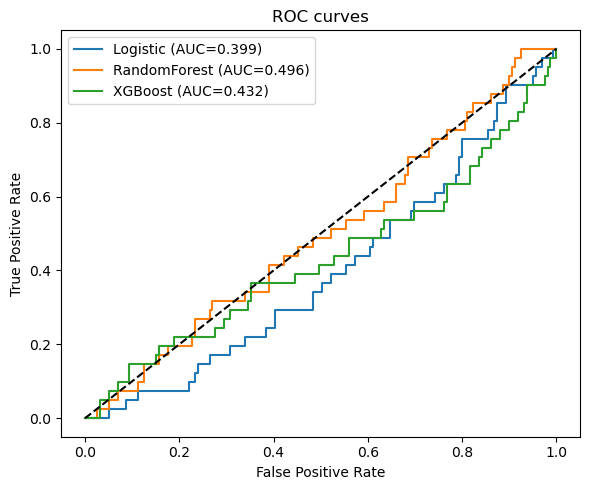

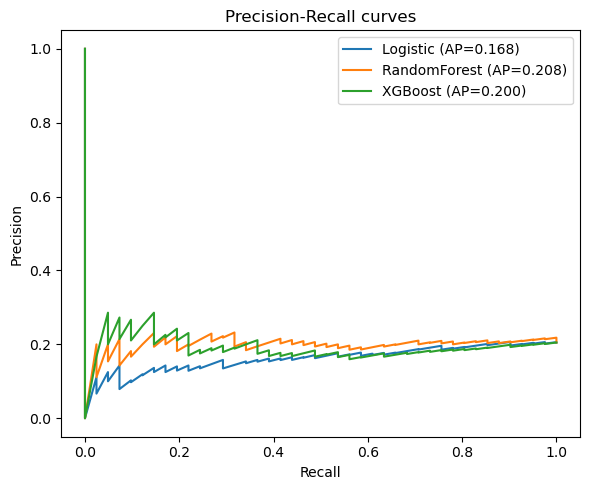

In [19]:
# Cell 10
def plot_roc_pr(y_test, proba, label, color='C0'):
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc_score(y_test, proba):.3f})")
    
plt.figure(figsize=(6,5))
plot_roc_pr(y_test, y_proba, 'Logistic')
plot_roc_pr(y_test, y_proba_rf, 'RandomForest')
plot_roc_pr(y_test, y_proba_xgb, 'XGBoost')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(figs, "roc_comparison.png"), dpi=300)
plt.show()

# Precision-Recall
from sklearn.metrics import precision_recall_curve
plt.figure(figsize=(6,5))
for proba, label in [(y_proba, 'Logistic'), (y_proba_rf, 'RandomForest'), (y_proba_xgb, 'XGBoost')]:
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(recall, precision, label=f"{label} (AP={ap:.3f})")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall curves')
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(figs, "pr_comparison.png"), dpi=300)
plt.show()


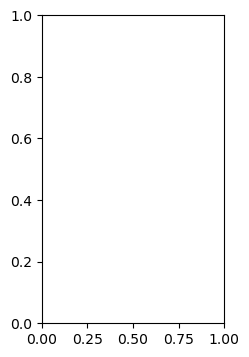

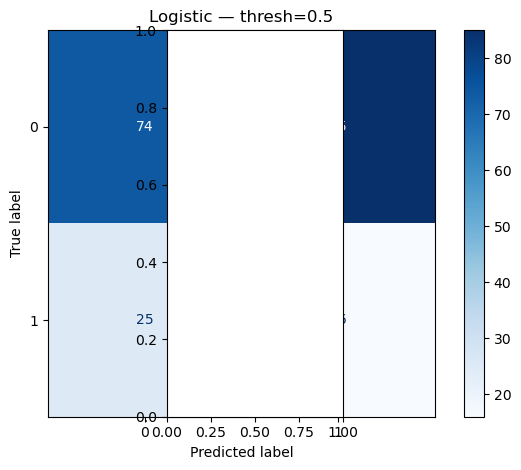

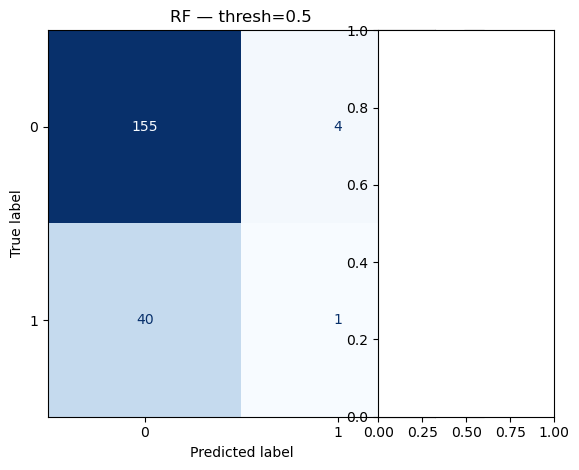

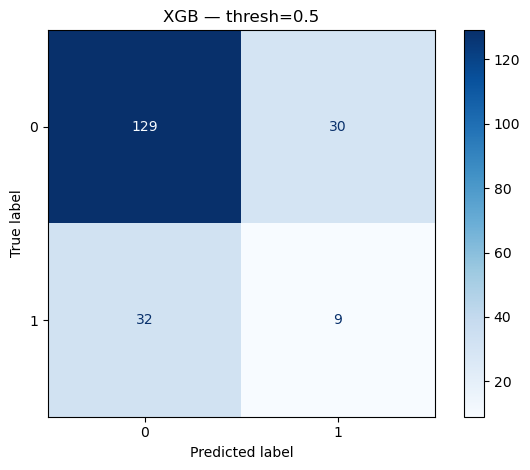

In [20]:
# Cell 11
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

def show_confmat(y_true, proba, thresh=0.5, title=""):
    y_pred_thresh = (proba >= thresh).astype(int)
    cm = confusion_matrix(y_true, y_pred_thresh)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(cmap='Blues')
    plt.title(f"{title} — thresh={thresh}")
    plt.tight_layout()
    return cm

plt.figure(figsize=(8,4))
plt.subplot(1,3,1)
show_confmat(y_test, y_proba, 0.5, "Logistic")
plt.subplot(1,3,2)
show_confmat(y_test, y_proba_rf, 0.5, "RF")
plt.subplot(1,3,3)
show_confmat(y_test, y_proba_xgb, 0.5, "XGB")
plt.savefig(os.path.join(figs, "confusion_matrices.png"), dpi=300)
plt.show()


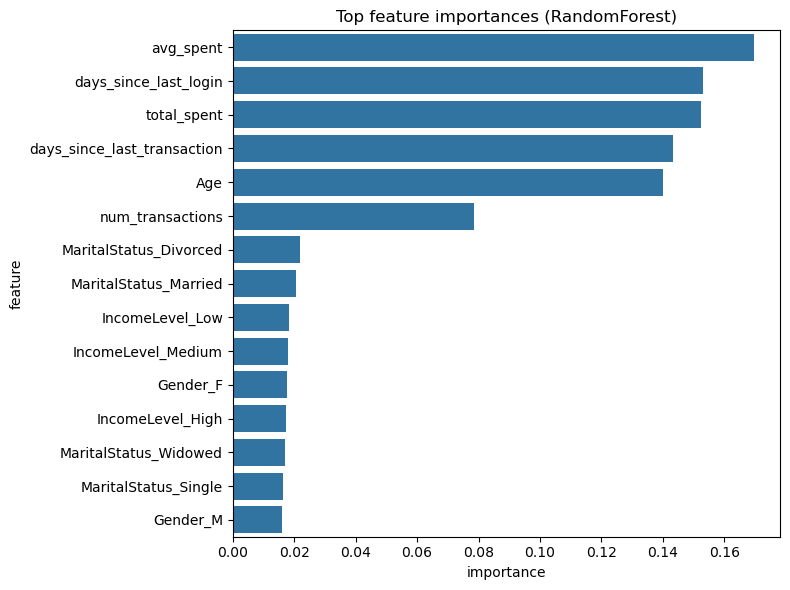

In [21]:
# Cell 12
# Feature importance for RandomForest (post-preprocessing trick to get feature names)
# Extract transformed column names
ohe_cols = []
if cat_cols:
    # get categories from fitted onehot encoder
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(cat_cols).tolist()
else:
    cat_names = []
final_feat_names = num_cols + cat_names

# If using rf_best
importances = rf_best.named_steps['clf'].feature_importances_
imp_df = pd.DataFrame({'feature': final_feat_names, 'importance': importances})
imp_df = imp_df.sort_values('importance', ascending=False).head(20)
plt.figure(figsize=(8,6))
sns.barplot(data=imp_df, x='importance', y='feature')
plt.title("Top feature importances (RandomForest)")
plt.tight_layout()
plt.savefig(os.path.join(figs, "rf_feature_importance.png"), dpi=300)
plt.show()


 98%|===================| 1563/1600 [00:37<00:00]        

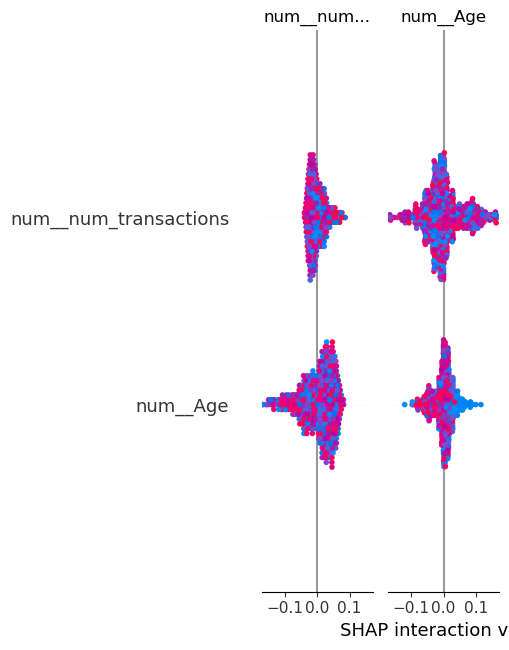

In [25]:
import shap

# Transform training data
X_train_trans = rf_best.named_steps['preproc'].transform(X_train)

# Get feature names directly from the fitted preprocessor
final_feat_names = rf_best.named_steps['preproc'].get_feature_names_out()

# Use modern SHAP API with additivity check disabled
# This addresses the numerical precision issue in the SHAP calculations
explainer = shap.Explainer(rf_best.named_steps['clf'], X_train_trans)
shap_vals = explainer(X_train_trans, check_additivity=False)  # Disable additivity check

# Plot summary
shap.summary_plot(shap_vals, X_train_trans, 
                  feature_names=final_feat_names, show=False)

plt.tight_layout()
plt.savefig(os.path.join(figs, "shap_summary.png"), dpi=300)
plt.show()

In [33]:
# Cell 14
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# First, let's check if X_train and X_test contain categorical variables
# and handle them appropriately

# Option 1: If you need to encode categorical variables in X
# This assumes X_train and X_test are pandas DataFrames
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

if len(categorical_cols) > 0:
    # For each categorical column, apply encoding
    for col in categorical_cols:
        # Option 1a: Label Encoding (if the variable is ordinal)
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
        
        # Option 1b: One-Hot Encoding (alternative for nominal variables)
        # enc = OneHotEncoder(sparse=False, drop='first')
        # encoded_train = enc.fit_transform(X_train[[col]])
        # encoded_test = enc.transform(X_test[[col]])
        # # Add encoded columns to X_train and X_test
        # for i in range(encoded_train.shape[1]):
        #     X_train[f"{col}_{i}"] = encoded_train[:, i]
        #     X_test[f"{col}_{i}"] = encoded_test[:, i]
        # # Drop original column
        # X_train = X_train.drop(col, axis=1)
        # X_test = X_test.drop(col, axis=1)

# Option 2: If y contains categorical values
if y_train.dtype == 'object' or y_train.dtype.name == 'category':
    le_y = LabelEncoder()
    y_train = le_y.fit_transform(y_train)
    y_test = le_y.transform(y_test)

# Now train the model with the processed data
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)

# Now use the trained model
yhat = best_model.predict(X_test)
yhat_proba = best_model.predict_proba(X_test)[:,1]

metrics = {
    'accuracy': accuracy_score(y_test, yhat),
    'precision': precision_score(y_test, yhat),
    'recall': recall_score(y_test, yhat),
    'f1': f1_score(y_test, yhat),
    'roc_auc': roc_auc_score(y_test, yhat_proba),
    'average_precision': average_precision_score(y_test, yhat_proba)
}
print(metrics)

# Make sure 'out' variable is defined, or replace with an actual path
# If 'out' is not defined, you can use:
import seaborn as sns
import matplotlib.pyplot as plt
import os  # Import the os module

# Define the save path
save_path = r"C:\Users\HP\Desktop\Lloyds_Task2"  # Using raw string (r) to handle Windows backslashes


{'accuracy': 0.785, 'precision': 0.3333333333333333, 'recall': 0.04878048780487805, 'f1': 0.0851063829787234, 'roc_auc': 0.5001533977603927, 'average_precision': 0.25391148658618173}


In [34]:
# Ensure target is named 'churn' and numeric 0/1
if 'churn' in df.columns:
    y = df['churn']
elif 'ChurnStatus' in df.columns:
    y = df['ChurnStatus']
    df.rename(columns={'ChurnStatus':'churn'}, inplace=True)
    y = df['churn']
else:
    raise ValueError("No churn column found. Rename target to 'churn' or 'ChurnStatus'.")

print("Churn distribution (counts):")
print(y.value_counts())
print("\nChurn distribution (%):")
print(y.value_counts(normalize=True).mul(100).round(2))


Churn distribution (counts):
churn
0    796
1    204
Name: count, dtype: int64

Churn distribution (%):
churn
0    79.6
1    20.4
Name: proportion, dtype: float64


In [35]:
# Update this list if your column names differ.
candidate_features = [
    'Age', 'Gender', 'MaritalStatus', 'IncomeLevel',
    'num_transactions', 'total_spent', 'avg_spent', 'num_unique_categories',
    'login_frequency', 'days_since_last_login', 'days_since_last_transaction',
    # any service_* dummy columns created earlier will be automatically included if present
]

# keep only features that exist in df
features = [f for f in candidate_features if f in df.columns]
# also include any service_ or cat_ columns already present
extra_cols = [c for c in df.columns if c.startswith('service_') or c.startswith('cat_')]
for c in extra_cols:
    if c not in features:
        features.append(c)

X = df[features].copy()
print("Using features:", features)
X.head()


Using features: ['Age', 'Gender', 'MaritalStatus', 'IncomeLevel', 'num_transactions', 'total_spent', 'avg_spent', 'days_since_last_login', 'days_since_last_transaction']


,Age,Gender,MaritalStatus,IncomeLevel,num_transactions,total_spent,avg_spent,days_since_last_login,days_since_last_transaction
0,62,M,Single,Low,1,416.50,416.50000,775,645
1,65,M,Married,Low,7,1547.42,221.06000,730,408
2,18,M,Single,Low,6,1702.98,283.83000,750,450
3,21,M,Widowed,Low,5,917.29,183.45800,832,370
4,21,M,Divorced,Medium,8,2001.49,250.18625,769,376


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, df['churn'], test_size=0.2, random_state=42, stratify=df['churn'])

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (800, 9) Test: (200, 9)


In [38]:
# XGBoost can use scale_pos_weight to counter imbalance. This is a safe starting heuristic.
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight = max(1, n_neg / max(1, n_pos))
print("Train positives:", n_pos, "negatives:", n_neg, "scale_pos_weight:", round(scale_pos_weight,2))


Train positives: 163 negatives: 637 scale_pos_weight: 3.91


In [40]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__gamma': [0, 0.1, 1],
    'clf__scale_pos_weight': [scale_pos_weight, max(1, scale_pos_weight/2), max(1, scale_pos_weight*2)]
}

rs = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist, n_iter=20,
                        scoring='roc_auc', cv=cv, random_state=42, n_jobs=-1, verbose=1)

rs.fit(X_train, y_train)
print("Best CV ROC-AUC:", rs.best_score_.round(4))
print("Best params:", rs.best_params_)


Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best CV ROC-AUC: 0.5883
Best params: {'clf__subsample': 1.0, 'clf__scale_pos_weight': 3.9079754601226995, 'clf__n_estimators': 200, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__gamma': 0, 'clf__colsample_bytree': 1.0}


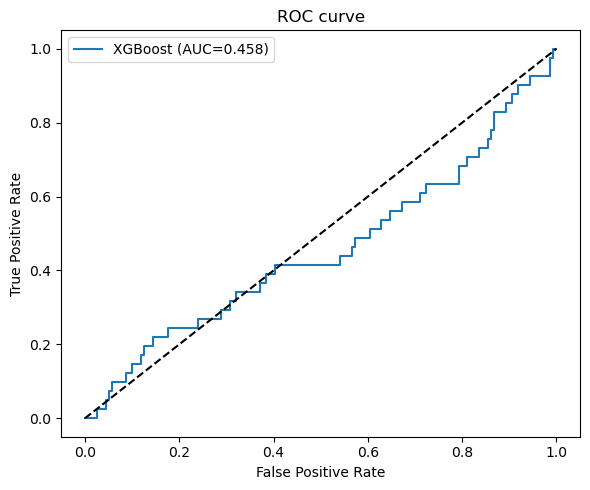

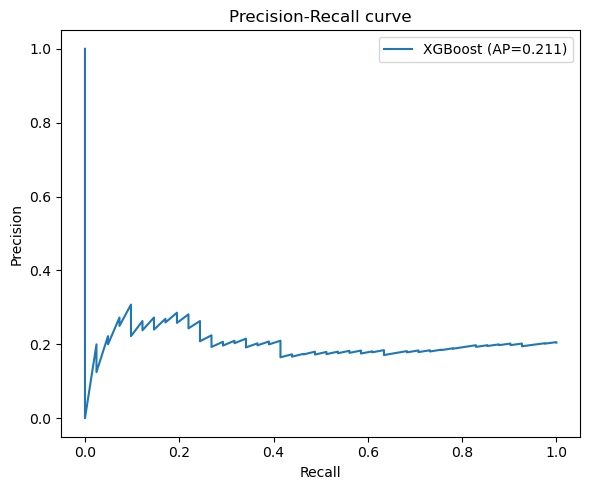

In [42]:
plt.figure(figsize=(6,5))
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"XGBoost (AUC={roc_auc_score(y_test, y_proba):.3f})")
# baseline (if you want to compare with logistic or rf, add their probs)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figs, "xgb_roc.png"), dpi=300)
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"XGBoost (AP={average_precision_score(y_test, y_proba):.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figs, "xgb_pr.png"), dpi=300)
plt.show()


In [46]:
import os
import joblib
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score

# Define your target save directory
models_dir = r"C:\Users\HP\Desktop\Lloyds_Task2\models"

# Ensure the directory exists
os.makedirs(models_dir, exist_ok=True)

# --- Save best XGBoost pipeline ---
joblib.dump(best_xgb, os.path.join(models_dir, "xgb_best_pipeline.joblib"))
print("✅ Saved XGBoost pipeline to:", os.path.join(models_dir, "xgb_best_pipeline.joblib"))

# --- Save performance metrics ---
metrics = {
    'roc_auc': roc_auc_score(y_test, y_proba),
    'pr_auc': average_precision_score(y_test, y_proba),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred)
}

metrics_path = os.path.join(models_dir, "xgb_metrics.csv")
pd.Series(metrics).to_csv(metrics_path)
print("✅ Saved metrics to:", metrics_path)


✅ Saved XGBoost pipeline to: C:\Users\HP\Desktop\Lloyds_Task2\models\xgb_best_pipeline.joblib
✅ Saved metrics to: C:\Users\HP\Desktop\Lloyds_Task2\models\xgb_metrics.csv
